<blockquote>
    <h1>Exercise 6.11</h1>
    <p>We will now try to predict per capita crime rate in the <code>Boston</code> data set.</p>
    <ol>
        <li>Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.</li>
        <li>Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.</li>
        <li>Does your chosen model involve all of the features in the data set? Why or why not?</li>
    </ol>
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
def fit_linear_reg(df_X, df_Y):
    # Fit linear regression model and return RSS values
    model = LinearRegression()
    _ = model.fit(df_X, df_Y)
    Y_pred = model.predict(df_X)    
    return mean_squared_error(df_Y, Y_pred)

<h3>Exercise 6.11.1</h3>
<blockquote>
    <i>Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.</i>
</blockquote>

In [3]:
# crim: per capita crime rate by town.
# zn: proportion of residential land zoned for lots over 25,000 sq.ft.
# indus: proportion of non-retail business acres per town.
# chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
# nox: nitrogen oxides concentration (parts per 10 million).
# rm: average number of rooms per dwelling.
# age: proportion of owner-occupied units built prior to 1940.
# dis: weighted mean of distances to five Boston employment centres.
# rad: index of accessibility to radial highways.
# tax: full-value property-tax rate per $10,000.
# ptratio: pupil-teacher ratio by town.
# black: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
# lstat: lower status of the population (percent).
# medv: median value of owner-occupied homes in $1000s.

df = pd.read_csv("../../DataSets/Boston/Boston.csv")
df.head()

df_Y = df[['crim']]
df_X = df.drop('crim', axis=1)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df_X)

df_X_train, df_X_test = train_test_split(df_X, test_size=0.2, random_state=0)
df_Y_train, df_Y_test = train_test_split(df_Y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(df_X_train)
df_X_train = pd.DataFrame(X_train, columns=df_X.columns)
X_test = scaler.transform(df_X_test)
df_X_test = pd.DataFrame(X_test, columns=df_X.columns)

results = {}

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


,variables,training MSE,testing MSE
number of predictors,,,
0,[Intercept],104.904,103.634
1,[rad],40.1883,64.2439
2,"[rad, lstat]",37.8824,62.6183
3,"[zn, rad, lstat]",37.6563,62.5768
4,"[rm, rad, lstat, medv]",37.33,63.1647
5,"[zn, dis, rad, lstat, medv]",37.0246,60.5715
6,"[zn, indus, dis, rad, lstat, medv]",36.6197,60.2978
7,"[zn, indus, rm, dis, rad, lstat, medv]",36.3765,61.2067
8,"[zn, nox, rm, dis, rad, ptratio, lstat, medv]",36.1558,60.4753


'mse = 60'

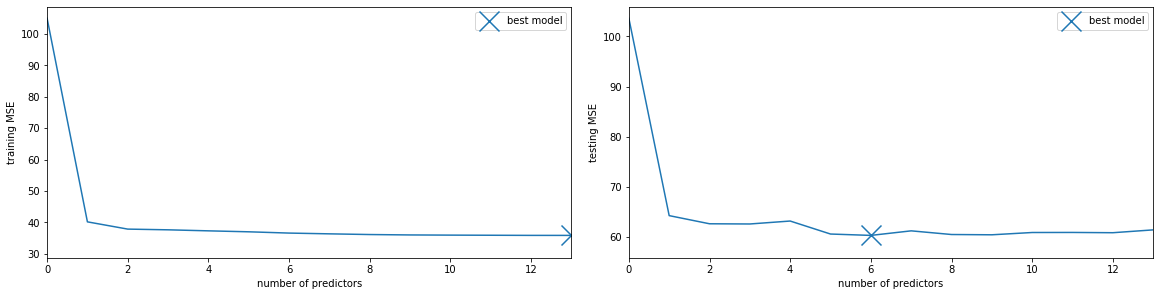

In [4]:
# best subset selection

best_submodels = {}
n, p = df_X.shape
MSE = np.sum((df_Y_test - df_Y_train.mean().iloc[0])**2).iloc[0] / df_Y_test.shape[0]  # null model
best_submodels = {
    0: (['Intercept'], MSE),  # null model
}

features_lst = df_X.columns.tolist()
for k in range(1, p + 1):
    MSE_min_subset = float('+inf')
    #Looping over all possible combinations: from p choose k
    for descriptiveColumns in itertools.combinations(features_lst, k):
        descriptiveColumns = list(descriptiveColumns)
        MSE = fit_linear_reg(df_X_train[descriptiveColumns], df_Y_train)
        if MSE < MSE_min_subset:
            MSE_min_subset = MSE
            descriptiveColumns_best_subset = descriptiveColumns
        
    best_submodels[k] = (descriptiveColumns_best_subset, MSE_min_subset)

for k, (descriptiveColumns_best_subset, MSE_train) in best_submodels.items():
    if descriptiveColumns_best_subset == ['Intercept']:  # null model
        Y_test_mean = df_Y_test.mean().iloc[0]
        MSE_test = np.sum((df_Y_test - Y_test_mean)**2).iloc[0] / df_Y_test.shape[0]
        best_submodels[k] = (descriptiveColumns_best_subset, MSE_train, MSE_test)
        continue

    model = LinearRegression()
    _ = model.fit(df_X_train[descriptiveColumns_best_subset], df_Y_train)
    
    Y_pred = model.predict(df_X_test[descriptiveColumns_best_subset])
    MSE_test = mean_squared_error(Y_pred, df_Y_test)
    best_submodels[k] = (descriptiveColumns_best_subset, MSE_train, MSE_test)


df_best_submodels = pd.DataFrame(best_submodels, index=['variables', 'training MSE', 'testing MSE']).T
df_best_submodels.index.name = 'number of predictors'
df_best_submodels

# df_best_submodels
df_best_MSE_train = df_best_submodels[df_best_submodels['training MSE'] == df_best_submodels['training MSE'].min()]
df_best_MSE_test = df_best_submodels[df_best_submodels['testing MSE'] == df_best_submodels['testing MSE'].min()]

numberOfSubplots = 2
fig, [ax1, ax2] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_best_submodels['training MSE'].plot(ax=ax1, label='')
_ = ax1.scatter(x=df_best_MSE_train.index[0], y=df_best_MSE_train['training MSE'].iloc[0], marker='x', s=400, label='best model')
_ = ax1.set_ylabel('training MSE')
_ = ax1.legend()

_ = df_best_submodels['testing MSE'].plot(ax=ax2, label='')
_ = ax2.scatter(x=df_best_MSE_test.index[0], y=df_best_MSE_test['testing MSE'].iloc[0], marker='x', s=400, label='best model')
_ = ax2.set_ylabel('testing MSE')
_ = ax2.legend()

results['linear'] = df_best_MSE_test['testing MSE'].iloc[0]
f"mse = {results['linear']:.0f}"

'test error for best model is: 61 with lambda = 0.1'

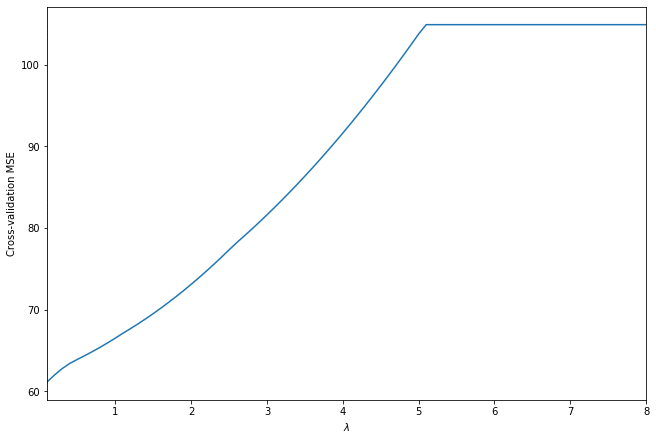

In [5]:
# lasso regression

stop = 8
num = 80
start = stop / num
lambda_arr = np.linspace(start=start, stop=stop, num=num)
mse_arr = np.empty(shape=lambda_arr.shape)
for index, lambda_ in enumerate(lambda_arr):
    model = Lasso(alpha=lambda_)
    _ = model.fit(X_train, df_Y_train)
        
    Y_pred = model.predict(X_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)

df_lasso_results = pd.DataFrame({
    'lambda': lambda_arr,
    'MSE': mse_arr,
})
lambda_min_mse = df_lasso_results.loc[df_lasso_results['MSE'].idxmin(), 'lambda']

numberOfSubplots = 1
fig, ax1 = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(9*numberOfSubplots, 6))

_ = df_lasso_results.plot(x='lambda', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel(r'$\lambda$')

results['lasso'] = df_lasso_results[df_lasso_results['lambda'] == lambda_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['lasso']:.0f} with lambda = {lambda_min_mse}"

'test error for best model is: 61 with lambda = 10.0'

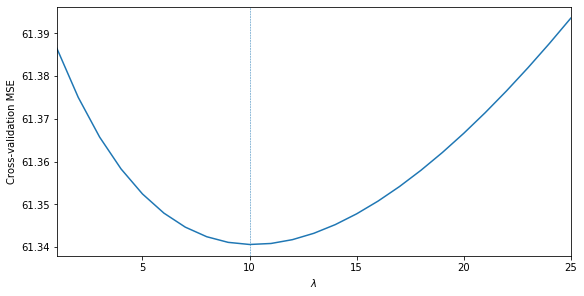

In [6]:
# ridge regression

stop = 25
num = 25
start = stop / num
lambda_arr = np.linspace(start=start, stop=stop, num=num)
mse_arr = np.empty(shape=lambda_arr.shape)
coef_arr = np.empty(shape=(lambda_arr.shape[0], p))
for index, lambda_ in enumerate(lambda_arr):
    model = Ridge(alpha=lambda_)
    _ = model.fit(X_train, df_Y_train)
        
    Y_pred = model.predict(X_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)

df_ridge_results = pd.DataFrame({
    'lambda': lambda_arr,
    'MSE': mse_arr,
})
lambda_min_mse = df_ridge_results.loc[df_ridge_results['MSE'].idxmin(), 'lambda']

numberOfSubplots = 1
fig, ax1 = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_ridge_results.plot(x='lambda', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel(r'$\lambda$')

results['ridge'] = df_ridge_results[df_ridge_results['lambda'] == lambda_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['ridge']:.0f} with lambda = {lambda_min_mse}"

'test error for best model is: 60 with 3 principal components'

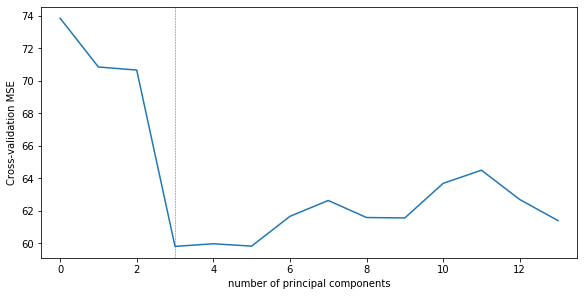

In [7]:
# PCR

stop = df_X.shape[1]
num = df_X.shape[1] + 1
start = 0
m_components_arr = np.linspace(start=start, stop=stop, num=num, dtype=int)
mse_arr = np.empty(shape=m_components_arr.shape)
for index, m_components in enumerate(m_components_arr):
    if index == 0:
        Y_mean = df_Y.mean().iloc[0]
        mse_arr[index] = np.sum((df_Y - Y_mean)**2).iloc[0] / n
        continue
        
    # training the model with standardized training set
    pca_model = PCA(n_components=m_components)
    principalComponents_train = pca_model.fit_transform(X_train)
    linreg_model = LinearRegression()
    _ = linreg_model.fit(principalComponents_train, df_Y_train)
        
    # assessing performance of model on standardized test data
    principalComponents_test = pca_model.transform(X_test)
    Y_pred = linreg_model.predict(principalComponents_test)
    mse_arr[index] = mean_squared_error(df_Y_test, Y_pred)
    
df_pca_results = pd.DataFrame({
    'M': m_components_arr,
    'MSE': mse_arr,
})
m_min_mse = df_pca_results.loc[df_pca_results['MSE'].idxmin(), 'M']

numberOfSubplots = 1
fig, ax1 = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_pca_results.plot(x='M', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=m_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel('number of principal components')
_ = ax1.set_xlim((-0.5, stop + 0.5))

results['pca'] = df_pca_results[df_pca_results['M'] == m_min_mse]['MSE'].iloc[0]
f"test error for best model is: {results['pca']:.0f} with {m_min_mse:.0f} principal components"

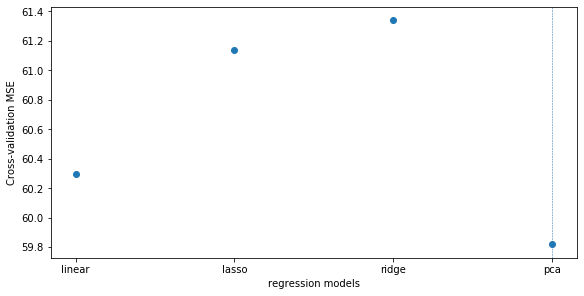

In [8]:
# compare models

models = results.keys()
mse_results = results.values()
best_overall_model = min(results, key=results.get)

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 4))
_ = ax1.scatter(models, mse_results)
_ = ax1.axvline(x=best_overall_model, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel('regression models')

<h3>Exercise 6.11.2</h3>
<blockquote>
    <i>Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.</i>
</blockquote>

<p>From the above results, it appears that the principal component regression performs the best on the test data.</p>

<h3>Exercise 6.11.3</h3>
<blockquote>
    <i>Does your chosen model involve all of the features in the data set? Why or why not?</i>
</blockquote>

<p>Yes, the principal components are a linear combination of all $p$ of the original features.</p>